In [10]:
import re
import pandas as pd
import numpy as np
import time
import json
import requests

In [183]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['font.sans-serif'] = ['SimHei'] 

In [5]:
def analysis_openid_from_profile(profile_url):
    return re.split('&|\?',profile_url)[1].split('=')[1]

In [6]:
def get_front_rank(rank):
    return re.findall('[\u4e00-\u9fa5]{2,4}', rank)[0]

## session_id 为每次登陆时服务端返回的id

In [312]:
session_id ='3hYx_I9PlFy_8ziFwMI5iZBMDkU9REbxf2J96aLXSV0'

# 获取朋友圈可见好友信息

In [14]:
header ={
'Host': 'game.weixin.qq.com',
    'Accept': '*/*',
    'User-Agent': 'Mozilla/5.0 (iPhone; CPU iPhone OS 12_0 like Mac OS X) AppleWebKit/605.1.15 (KHTML, like Gecko) Mobile/16A366 MicroMessenger/7.0.4(0x17000428) NetType/WIFI Language/zh_CN QBWebViewType/1 WKType/1',
    'Accept-Language': 'zh-cn',
    'Referer': 'https://game.weixin.qq.com/cgi-bin/h5/static/playrank/index.html?appid=wxc4c0253df149f02d&wechat_pkgid=playrank_index&ssid=2306&useGameOpen=true&abt=26&rpt_allpath=2402_2306'
#     'https://game.weixin.qq.com/cgi-bin/gamewap/getfeatureranklist2?appid=wxc4c0253df149f02d&is_installed=&time_type=2&rank_type=5&method=GET&abtest_cookie=&abt=26&pass_ticket=v3vPu4l%2Ff3QjwV29bKfibUObo8Qoau8ItQmzV%2FRwA3uym6vuZsFeWi9zmkBky4ro&QB&'
}

In [52]:
def get_friends_info():
    Cookie = {
        'X-WECHAT-KEY':'6b93f7d94c07b3156a913ca1aa64578f7f4a3d5229c932cfb4f8726dcbea99cb4fa0ba33b716598ea704c76fb06d415c89540d83855f5d88f16aba2ba7d0461334b9955aa49878f0de46bedade93b881',
        'X-WECHAT-UIN':'MTQyMTQ1NDAwNw%3D%3D',
        'key':'72d10ca0e413b6f8e8305e498fe575e776eb7d103379b37b99715e66aba6db73fea51a7e32eb72363e292b3a39b1d07b15860fc38ca0edaab8dfb3e2eefa1d797f5041647c71c2c2cf3577e8cdf96ef6', 
        'pass_ticket':'2vRL0IdjRs8OWUb2%2F0TF4RuGRc1SGDY7oEfFu9ZkphVCNXoqIspg%2FHrnbTznXY1y',
        'uin':'MTQyMTQ1NDAwNw%3D%3D', 
        'qv_als':'WqhYHx1vmXjIgmBvA11559272040hRwTXw=='
           } 
    params ={'appid':'wxc4c0253df149f02d',
             'time_type':'2',
             'rank_type':'5',
             'method':'GET',
             'abt':'26',
             'pass_ticket':'2vRL0IdjRs8OWUb2/0TF4RuGRc1SGDY7oEfFu9ZkphVCNXoqIspg/HrnbTznXY1y'
    }
    url = 'https://game.weixin.qq.com/cgi-bin/gamewap/getfeatureranklist2?'
    r = requests.get(url, params=params, headers = header, cookies = Cookie)
    return r.json()

In [20]:
j = get_friends_info()

In [22]:
nick_name, profile_info =[], []
for player in j['rank_list'][0]['friendranklist']:
    nick_name.append(player['nick'])
    profile_info.append(player['user_profile_url'])

In [23]:
df = pd.DataFrame({'name':nick_name, 'profile_info':profile_info})

# 得到每个玩家的 open_id

In [49]:
def get_open_id_from_profile(df):
    profile_info_split = df['profile_info'].split('=')[1]
    Cookie={
        'key':'9548d512ad2c21872b07bdbc1227f2e4da6928dc11896052462bbb1ef0ad6cbe637de48b6386bac727fb24799fee2385974eb39240ac8c8cb728c7ee9bf55ad5287f2e797bc03058d7ef2b999612c478',
        'pass_ticket':'2vRL0IdjRs8OWUb2%2F0TF4RuGRc1SGDY7oEfFu9ZkphVCNXoqIspg%2FHrnbTznXY1y',
        'uin':'MTQyMTQ1NDAwNw%3D%3D',
        'qv_als':'gOMw5bDJePp+e7DVA11559274764MpW5Lw=='      
    }
    params ={
        'abtest_cookie':'BAABAAoACwASABMABgAjlx4AVpkeAMSZHgDcmR4A%2BJkeAAOaHgAAAA%3D%3D',
             't':profile_info_split,
             'method':'GET',
             'abt':'26',
             'pass_ticket':'2vRL0IdjRs8OWUb2/0TF4RuGRc1SGDY7oEfFu9ZkphVCNXoqIspg/HrnbTznXY1y',
             'QB':''
    }
    url = 'https://game.weixin.qq.com/cgi-bin/gamewap/getprofile2?'
    r = requests.get(url, headers = header, params=params, cookies = Cookie)
#     print(params)
    for game in r.json()['my_game']['game_list']:
        if game['app_name'] == '和平精英':
#             print(game)
            jump_url = game['jump_url']
#             print(jump_url)
            df['open_id'] = analysis_openid_from_profile(jump_url)
    return df

In [50]:
df = df.apply(get_open_id_from_profile, axis = 1)

In [53]:
del df['profile_info']

# 最高击杀

In [56]:
def get_highest_kill(df):
    url = 'https://game.weixin.qq.com/cgi-bin/gamewap/getjdqssydatacenterindex?'
    params = {
        'session_id':session_id,
        'openid':df['open_id']
    }
    r = requests.get(url, params = params)
#     print(r.json())
#     r.json()['achievement'][0]
#     print(r.json())
    j = r.json()['achievement']['achievement_list'][0]
    df['highest_kill_info'] = []
    info ={}
    info['title'] = j['title']
    info['team_id'] = j['team_id']
    info['battle_id'] = j['battle_id']
    info['mode'] = j['mode']
    info['plat_id'] = j['plat_id']
    info['dt_event_time'] = j['dt_event_time']
    info['type'] = j['type']
    df['highest_kill_info'].append(info)
    return df

In [369]:
df['highest_kill_info'][0]

[{'battle_id': 179228164960303991,
  'dt_event_time': 1520171010,
  'mode': 101,
  'plat_id': 0,
  'team_id': 0,
  'title': '历史最高淘汰 16人',
  'type': 1}]

In [57]:
df =df.apply(get_highest_kill, axis = 1)

# 最高击杀所击杀机器人 列表为空表示数据查询不到

In [59]:
def get_kill_id(df, index_name):
    url = 'https://game.weixin.qq.com/cgi-bin/gamewap/getjdqssybattledetail?'
    params = {
        'session_id':session_id,
        'openid':df['open_id'],
        'team_id':df[index_name][0]['team_id'],
        'plat_id':df[index_name][0]['plat_id'],
        'battle_id':df[index_name][0]['battle_id'],
        'mode':df[index_name][0]['mode'],
        'dt_event_time':df[index_name][0]['dt_event_time'],
        'type':df[index_name][0]['type'] # default 1
    }
#     print(params)
    r = requests.get(url, params = params)
    time.sleep(2)
#     print(r.json())
    killed_player_id = []
    robot_num = 0
    df['highest_kill_rob_info'] = []
    print(r.json()['errmsg'])
    
    if r.json()['errcode'] == 0:
        kill_list = r.json()['prey_info']['prey_list']
#         print(kill_list)
#         print("*"*10)
        if len(kill_list) == 0:
            df['highest_kill_rob_info'] = []
        for killed_player in kill_list:
            # identify robot
            if str(params['battle_id']) in analysis_openid_from_profile(killed_player['profile_url']):
                robot_num+=1

        kill_info ={}
        kill_info['kill_all_num'] = len(kill_list)
        kill_info['kill_rob_num'] = robot_num
#         print(kill_info)
        df['highest_kill_rob_info'].append(kill_info)
    return df

In [60]:
df = df.apply(get_kill_id,args={'highest_kill_info'}, axis = 1)

system error
system error
system error
ok
ok
ok
ok
ok
ok
ok
ok
ok
system error
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok
ok


In [398]:
df['highest_kill_info'][12]

[{'battle_id': 179228164960303991,
  'dt_event_time': 1520171010,
  'mode': 101,
  'plat_id': 0,
  'team_id': 0,
  'title': '历史最高淘汰 16人',
  'type': 1}]

# 获取赛季战绩列表

In [63]:
def get_battle_list(session_id, openid, after_time, all_battle_list, plat_id):
    get_battle_list_url = 'https://game.weixin.qq.com/cgi-bin/gamewap/getjdqssybattlelist?session_id={0}&openid={1}&limit=20&after_time={2}&plat_id={3}&mode_type=2'.format(session_id, openid, after_time, plat_id)
    r = requests.get(get_battle_list_url)
    time.sleep(2)
    json_file = r.json()
    print(json_file['errmsg'])    
    for each_fight in json_file['battle_list']:
        if each_fight['season'] != 0:
#             print(each_fight)
            info ={}
            info['team_id'] = each_fight['team_id']
            info['battle_id'] = each_fight['battle_id']
            info['mode'] = each_fight['mode']
    #         info['plat_id'] = each_fight['plat_id']
            info['dt_event_time'] = each_fight['dt_event_time']
            info['rank_desc'] = each_fight['rank_desc']
            all_battle_list.append(info)
#     print(json_file)
    
    return json_file['has_next'], json_file['next_after_time']

In [64]:
# 获取最近比赛场次信息 分手机平台

def get_all_battle(df):
    plat_ios = 0
    plat_Android = 1
    
    
    all_battle_list = []
    list_Android = []
    list_ios = []
    
    # fetch ios battle list
    has_next_flag = True
    next_after_time = 0
    while(has_next_flag):
        has_next_flag, next_after_time = get_battle_list(session_id, df['open_id'], next_after_time, list_ios, plat_ios)
    print('fetch {0} ios battles'.format(len(list_ios)))
    all_battle_list.append(list_ios)
    
    # fetch Android battle list
    next_after_time = 0
    has_next_flag = True

    while(has_next_flag):
        has_next_flag, next_after_time = get_battle_list(session_id, df['open_id'], next_after_time, list_Android, plat_Android)
    print('fetch {0} Android battles'.format(len(list_Android)))
    all_battle_list.append(list_Android)
    
    df['recent_list'] = all_battle_list
    return df

In [66]:
df['recent_list'] = None 

In [68]:
df = df.apply(get_all_battle, axis = 1)

ok
ok
ok
ok
ok
ok
fetch 109 ios battles
ok
fetch 0 Android battles
ok
ok
ok
ok
ok
ok
fetch 109 ios battles
ok
fetch 0 Android battles
ok
ok
ok
ok
ok
ok
fetch 99 ios battles
ok
fetch 0 Android battles
ok
fetch 0 ios battles
ok
ok
ok
ok
ok
ok
fetch 89 Android battles
ok
ok
ok
ok
ok
ok
fetch 92 ios battles
ok
fetch 20 Android battles
ok
ok
ok
ok
ok
ok
fetch 110 ios battles
ok
fetch 0 Android battles
ok
fetch 0 ios battles
ok
ok
ok
ok
ok
ok
fetch 101 Android battles
ok
fetch 0 ios battles
ok
ok
ok
ok
ok
ok
fetch 110 Android battles
ok
ok
ok
ok
ok
ok
fetch 108 ios battles
ok
fetch 0 Android battles
ok
ok
ok
ok
ok
ok
fetch 102 ios battles
ok
fetch 0 Android battles
ok
fetch 0 ios battles
ok
ok
ok
ok
ok
ok
fetch 26 Android battles
ok
fetch 0 ios battles
ok
ok
ok
ok
ok
ok
fetch 91 Android battles
ok
fetch 0 ios battles
ok
ok
ok
ok
ok
ok
fetch 106 Android battles
ok
ok
ok
ok
ok
ok
fetch 105 ios battles
ok
fetch 4 Android battles
ok
ok
ok
ok
ok
ok
fetch 55 ios battles
ok
ok
ok
ok
ok
ok
fetch 91 

In [137]:
for i in df.index:
#     print(type(df.loc[i,'recent_list']))
    if df.loc[i,'recent_list'] in [None]:
        df.iloc[i:i+1,:] = df.iloc[i:i+1,:].apply(get_all_battle, axis = 1)
#         break
        print(i)

ok
ok
ok
ok
ok
ok
fetch 101 ios battles
ok
ok
ok
fetch 38 Android battles
ok
ok
ok
ok
ok
ok
fetch 101 ios battles
ok
ok
ok
fetch 38 Android battles
17
ok
ok
ok
ok
ok
fetch 93 ios battles
ok
fetch 0 Android battles
ok
ok
ok
ok
ok
fetch 93 ios battles
ok
fetch 0 Android battles
18
ok
ok
ok
ok
ok
ok
fetch 47 ios battles
ok
ok
ok
ok
ok
fetch 90 Android battles
ok
ok
ok
ok
ok
ok
fetch 47 ios battles
ok
ok
ok
ok
ok
fetch 90 Android battles
19
ok
ok
ok
ok
ok
ok
fetch 105 ios battles
ok
ok
ok
ok
ok
fetch 74 Android battles
ok
ok
ok
ok
ok
ok
fetch 105 ios battles
ok
ok
ok
ok
ok
fetch 74 Android battles
20
ok
fetch 0 ios battles
ok
ok
ok
ok
ok
ok
fetch 19 Android battles
ok
fetch 0 ios battles
ok
ok
ok
ok
ok
ok
fetch 19 Android battles
21
ok
ok
ok
ok
ok
ok
fetch 106 ios battles
ok
fetch 0 Android battles
ok
ok
ok
ok
ok
ok
fetch 106 ios battles
ok
fetch 0 Android battles
22
ok
ok
ok
ok
ok
ok
fetch 104 ios battles
ok
fetch 15 Android battles
ok
ok
ok
ok
ok
ok
fetch 104 ios battles
ok
fetch 15 Andr

# 从最近比赛场次获取机器人击杀信息

In [70]:
def get_recent_robot(df, index_name):
    url = 'https://game.weixin.qq.com/cgi-bin/gamewap/getjdqssybattledetail?'
    # different plant id
    #  plat_ios = 0
    # plat_Android = 1
    all_kill = []
    for i in range(2):
        plat_kill_info = []
#         print(df[index_name][i])
        for each_match in df[index_name][i]:
            print(each_match)
            each_kill =[]
            params = {
                'session_id':session_id,
                'openid':df['open_id'],
                'team_id':str(each_match['team_id']),
                'plat_id':str(i),
                'battle_id':str(each_match['battle_id']),
                'mode':str(each_match['mode']),
                'dt_event_time':str(each_match['dt_event_time'])
            }
#     print(params)
            r = requests.get(url, params = params)
            time.sleep(2)
    #     print(r.json())
 
            robot_num = 0
            
            print(r.json()['errmsg'])
            assert r.json()['errmsg']
            if r.json()['errcode'] == 0:
#                 print(r.json())
                
        #         print("*"*10)
                if r.json()['killing_count'] == 0:
                    each_kill = [0, 0]
                else:
                    kill_list = r.json()['prey_info']['prey_list']
                    for killed_player in kill_list:
                        # identify robot
                        if str(params['battle_id']) in analysis_openid_from_profile(killed_player['profile_url']):
                            robot_num+=1
                    each_kill.append([len(kill_list), robot_num])
        #         print(kill_info)
            plat_kill_info.append(each_kill)
        all_kill.append(plat_kill_info)    
    df['recent_kill_info'] = all_kill
    return df

In [73]:
df = df.apply(get_recent_robot, args ={'recent_list'}, axis = 1)

{'mode': 103, 'rank_desc': '星钻Ⅲ', 'dt_event_time': 1559133750, 'battle_id': '203182322986782712', 'team_id': 25}
ok
{'mode': 103, 'rank_desc': '星钻Ⅳ', 'dt_event_time': 1559132344, 'battle_id': '203182322986621139', 'team_id': 7}
ok
{'mode': 103, 'rank_desc': '星钻Ⅳ', 'dt_event_time': 1559131217, 'battle_id': '203182322986487824', 'team_id': 2}
ok
{'mode': 103, 'rank_desc': '星钻Ⅳ', 'dt_event_time': 1559130217, 'battle_id': '203182322986367111', 'team_id': 6}
ok
{'mode': 103, 'rank_desc': '星钻Ⅳ', 'dt_event_time': 1559129248, 'battle_id': '203182322986313251', 'team_id': 4}
ok
{'mode': 103, 'rank_desc': '星钻Ⅳ', 'dt_event_time': 1559128716, 'battle_id': '203182322986128669', 'team_id': 14}
ok
{'mode': 103, 'rank_desc': '星钻Ⅳ', 'dt_event_time': 1559127238, 'battle_id': '203182322986084726', 'team_id': 26}
ok
{'mode': 103, 'rank_desc': '星钻Ⅳ', 'dt_event_time': 1559127208, 'battle_id': '203182322985943070', 'team_id': 11}
ok
{'mode': 103, 'rank_desc': '星钻Ⅳ', 'dt_event_time': 1559126843, 'battle_id': 

ok
{'mode': 103, 'rank_desc': '皇冠Ⅲ', 'dt_event_time': 1556625785, 'battle_id': '164320885309803953', 'team_id': 14}
ok
{'mode': 103, 'rank_desc': '皇冠Ⅲ', 'dt_event_time': 1556625184, 'battle_id': '164320885309761841', 'team_id': 11}
ok
{'mode': 103, 'rank_desc': '皇冠Ⅲ', 'dt_event_time': 1556624854, 'battle_id': '164320885297393998', 'team_id': 15}
ok
{'mode': 103, 'rank_desc': '皇冠Ⅳ', 'dt_event_time': 1556276951, 'battle_id': '164320885284502440', 'team_id': 15}
system error
{'mode': 103, 'rank_desc': '皇冠Ⅳ', 'dt_event_time': 1556275466, 'battle_id': '164320885284401129', 'team_id': 15}
system error
{'mode': 103, 'rank_desc': '皇冠Ⅳ', 'dt_event_time': 1556274586, 'battle_id': '164320885283682024', 'team_id': 13}
system error
{'mode': 103, 'rank_desc': '皇冠Ⅳ', 'dt_event_time': 1556266952, 'battle_id': '164320885283631946', 'team_id': 15}
system error
{'mode': 103, 'rank_desc': '皇冠Ⅳ', 'dt_event_time': 1556266731, 'battle_id': '164320885283549010', 'team_id': 15}
system error
{'mode': 103, 'rank

ok
{'mode': 103, 'rank_desc': '星钻Ⅳ', 'dt_event_time': 1558785014, 'battle_id': '203182322959016520', 'team_id': 4}
ok
{'mode': 103, 'rank_desc': '星钻Ⅳ', 'dt_event_time': 1558781264, 'battle_id': '203182322958171915', 'team_id': 27}
ok
{'mode': 103, 'rank_desc': '星钻Ⅴ', 'dt_event_time': 1558777439, 'battle_id': '203182322957624573', 'team_id': 14}
ok
{'mode': 103, 'rank_desc': '星钻Ⅴ', 'dt_event_time': 1558777061, 'battle_id': '203182322957544622', 'team_id': 11}
ok
{'mode': 103, 'rank_desc': '星钻Ⅴ', 'dt_event_time': 1558771123, 'battle_id': '203182322956671786', 'team_id': 14}
ok
{'mode': 103, 'rank_desc': '星钻Ⅴ', 'dt_event_time': 1558769792, 'battle_id': '203182322956414815', 'team_id': 13}
ok
{'mode': 103, 'rank_desc': '星钻Ⅴ', 'dt_event_time': 1558769733, 'battle_id': '203182322956614653', 'team_id': 13}
ok
{'mode': 103, 'rank_desc': '星钻Ⅴ', 'dt_event_time': 1558707303, 'battle_id': '203182322950120068', 'team_id': 11}
ok
{'mode': 103, 'rank_desc': '星钻Ⅴ', 'dt_event_time': 1558702383, 'battle

system error
{'mode': 103, 'rank_desc': '皇冠Ⅴ', 'dt_event_time': 1554291509, 'battle_id': '164320885135756202', 'team_id': 15}
system error
{'mode': 103, 'rank_desc': '皇冠Ⅴ', 'dt_event_time': 1554122706, 'battle_id': '164320885125039808', 'team_id': 4}
system error
{'mode': 103, 'rank_desc': '皇冠Ⅴ', 'dt_event_time': 1554120880, 'battle_id': '164320885124821743', 'team_id': 6}
system error
{'mode': 103, 'rank_desc': '皇冠Ⅴ', 'dt_event_time': 1554119386, 'battle_id': '164320885124579487', 'team_id': 14}
system error
{'mode': 103, 'rank_desc': '皇冠Ⅴ', 'dt_event_time': 1554021637, 'battle_id': '164320885117538373', 'team_id': 14}
system error
{'mode': 103, 'rank_desc': '皇冠Ⅴ', 'dt_event_time': 1554020779, 'battle_id': '164320885117481855', 'team_id': 14}
system error
{'mode': 103, 'rank_desc': '皇冠Ⅴ', 'dt_event_time': 1554020420, 'battle_id': '164320885117430254', 'team_id': 14}
system error
{'mode': 103, 'rank_desc': '皇冠Ⅴ', 'dt_event_time': 1554019995, 'battle_id': '164320885117125842', 'team_id'

ok
{'mode': 103, 'rank_desc': '超级王牌', 'dt_event_time': 1557235472, 'battle_id': '164320885361075070', 'team_id': 13}
ok
{'mode': 103, 'rank_desc': '超级王牌', 'dt_event_time': 1557234813, 'battle_id': '164320885360845236', 'team_id': 14}
ok
{'mode': 103, 'rank_desc': '超级王牌', 'dt_event_time': 1557234553, 'battle_id': '164320885360950637', 'team_id': 2}
ok
{'mode': 101, 'rank_desc': '铂金Ⅲ', 'dt_event_time': 1557232969, 'battle_id': '164320885360694756', 'team_id': 29}
ok
{'mode': 103, 'rank_desc': '超级王牌', 'dt_event_time': 1557229458, 'battle_id': '164320885360235455', 'team_id': 12}
ok
{'mode': 103, 'rank_desc': '超级王牌', 'dt_event_time': 1557228557, 'battle_id': '164320885360212305', 'team_id': 15}
ok
{'mode': 103, 'rank_desc': '超级王牌', 'dt_event_time': 1557227889, 'battle_id': '164320885360085136', 'team_id': 13}
ok
{'mode': 103, 'rank_desc': '超级王牌', 'dt_event_time': 1557216182, 'battle_id': '164320885359217301', 'team_id': 4}
ok
{'mode': 103, 'rank_desc': '超级王牌', 'dt_event_time': 1557214393, 

system error
{'mode': 103, 'rank_desc': '星钻Ⅲ', 'dt_event_time': 1555339688, 'battle_id': '164320885221754043', 'team_id': 2}
system error
{'mode': 103, 'rank_desc': '星钻Ⅲ', 'dt_event_time': 1555339291, 'battle_id': '164320885221709482', 'team_id': 7}
system error
{'mode': 102, 'rank_desc': '黄金Ⅰ', 'dt_event_time': 1555323790, 'battle_id': '164320885219512756', 'team_id': 7}
system error
{'mode': 103, 'rank_desc': '星钻Ⅲ', 'dt_event_time': 1555148739, 'battle_id': '164320885205001569', 'team_id': 4}
system error
{'mode': 103, 'rank_desc': '星钻Ⅲ', 'dt_event_time': 1555085858, 'battle_id': '164320885200218994', 'team_id': 2}
system error
{'mode': 102, 'rank_desc': '黄金Ⅱ', 'dt_event_time': 1555084599, 'battle_id': '164320885200182017', 'team_id': 41}
system error
{'mode': 102, 'rank_desc': '黄金Ⅰ', 'dt_event_time': 1555084251, 'battle_id': '164320885200161663', 'team_id': 16}
system error
{'mode': 102, 'rank_desc': '黄金Ⅰ', 'dt_event_time': 1555044573, 'battle_id': '164320885195323495', 'team_id': 2

system error
{'mode': 103, 'rank_desc': '星钻Ⅰ', 'dt_event_time': 1556292832, 'battle_id': '164320885287082098', 'team_id': 4}
system error
{'mode': 103, 'rank_desc': '星钻Ⅰ', 'dt_event_time': 1556292523, 'battle_id': '164320885286939446', 'team_id': 7}
system error
{'mode': 103, 'rank_desc': '星钻Ⅱ', 'dt_event_time': 1555949461, 'battle_id': '164320885266273108', 'team_id': 2}
system error
{'mode': 103, 'rank_desc': '星钻Ⅱ', 'dt_event_time': 1555947555, 'battle_id': '164320885266165679', 'team_id': 3}
system error
{'mode': 103, 'rank_desc': '星钻Ⅱ', 'dt_event_time': 1555946407, 'battle_id': '164320885266126071', 'team_id': 4}
system error
{'mode': 103, 'rank_desc': '星钻Ⅱ', 'dt_event_time': 1555862677, 'battle_id': '164320885261179473', 'team_id': 2}
system error
{'mode': 103, 'rank_desc': '星钻Ⅰ', 'dt_event_time': 1555862294, 'battle_id': '164320885261156288', 'team_id': 1}
system error
{'mode': 103, 'rank_desc': '星钻Ⅰ', 'dt_event_time': 1555861945, 'battle_id': '164320885261061050', 'team_id': 1}


system error
{'mode': 102, 'rank_desc': '黄金Ⅳ', 'dt_event_time': 1554785757, 'battle_id': '164320885179435659', 'team_id': 9}
system error
{'mode': 102, 'rank_desc': '黄金Ⅳ', 'dt_event_time': 1554785388, 'battle_id': '164320885179420671', 'team_id': 19}
system error
{'mode': 102, 'rank_desc': '黄金Ⅳ', 'dt_event_time': 1554785185, 'battle_id': '164320885179348889', 'team_id': 13}
system error
{'mode': 103, 'rank_desc': '星钻Ⅲ', 'dt_event_time': 1554697217, 'battle_id': '164320885168729613', 'team_id': 3}
system error
{'mode': 103, 'rank_desc': '星钻Ⅲ', 'dt_event_time': 1554622534, 'battle_id': '164320885168531354', 'team_id': 25}
system error
{'mode': 103, 'rank_desc': '星钻Ⅲ', 'dt_event_time': 1554621255, 'battle_id': '164320885168485638', 'team_id': 3}
system error
{'mode': 103, 'rank_desc': '星钻Ⅲ', 'dt_event_time': 1554620874, 'battle_id': '164320885168427175', 'team_id': 24}
system error
{'mode': 103, 'rank_desc': '星钻Ⅲ', 'dt_event_time': 1554620490, 'battle_id': '164320885168363679', 'team_id':

system error
{'mode': 103, 'rank_desc': '铂金Ⅲ', 'dt_event_time': 1553958564, 'battle_id': '164320885112128240', 'team_id': 2}
system error
{'mode': 103, 'rank_desc': '铂金Ⅳ', 'dt_event_time': 1553956183, 'battle_id': '164320885111915834', 'team_id': 9}
system error
{'mode': 103, 'rank_desc': '铂金Ⅲ', 'dt_event_time': 1553955849, 'battle_id': '164320885106582287', 'team_id': 2}
system error
{'mode': 103, 'rank_desc': '铂金Ⅲ', 'dt_event_time': 1553922012, 'battle_id': '164320885106523752', 'team_id': 1}
system error
{'mode': 102, 'rank_desc': '黄金Ⅴ', 'dt_event_time': 1553921583, 'battle_id': '164320885106295185', 'team_id': 3}
system error
{'mode': 102, 'rank_desc': '黄金Ⅴ', 'dt_event_time': 1553920063, 'battle_id': '164320885106250237', 'team_id': 17}
system error
{'mode': 102, 'rank_desc': '黄金Ⅴ', 'dt_event_time': 1553919729, 'battle_id': '164320885106177319', 'team_id': 16}
system error
{'mode': 102, 'rank_desc': '黄金Ⅳ', 'dt_event_time': 1553919126, 'battle_id': '164320885106145499', 'team_id': 2

system error
{'mode': 103, 'rank_desc': '星钻Ⅳ', 'dt_event_time': 1550391767, 'battle_id': '164320884814091557', 'team_id': 4}
system error
{'mode': 103, 'rank_desc': '星钻Ⅳ', 'dt_event_time': 1550391215, 'battle_id': '164320884813831497', 'team_id': 2}
system error
{'mode': 103, 'rank_desc': '星钻Ⅳ', 'dt_event_time': 1550389717, 'battle_id': '164320884813507992', 'team_id': 26}
system error
{'mode': 103, 'rank_desc': '星钻Ⅳ', 'dt_event_time': 1550387896, 'battle_id': '164320884813381216', 'team_id': 5}
system error
{'mode': 103, 'rank_desc': '星钻Ⅳ', 'dt_event_time': 1550387197, 'battle_id': '164320884813196000', 'team_id': 2}
system error
{'mode': 103, 'rank_desc': '星钻Ⅳ', 'dt_event_time': 1550386131, 'battle_id': '164320884812851095', 'team_id': 3}
system error
{'mode': 103, 'rank_desc': '星钻Ⅳ', 'dt_event_time': 1550384134, 'battle_id': '164320884812716780', 'team_id': 26}
system error
{'mode': 103, 'rank_desc': '星钻Ⅴ', 'dt_event_time': 1550383398, 'battle_id': '164320884812635916', 'team_id': 1

system error
{'mode': 102, 'rank_desc': '铂金Ⅴ', 'dt_event_time': 1554111101, 'battle_id': '164320885123920061', 'team_id': 16}
system error
{'mode': 102, 'rank_desc': '铂金Ⅴ', 'dt_event_time': 1554110852, 'battle_id': '164320885123848433', 'team_id': 50}
system error
{'mode': 102, 'rank_desc': '铂金Ⅴ', 'dt_event_time': 1554098147, 'battle_id': '164320885122961985', 'team_id': 4}
system error
{'mode': 101, 'rank_desc': '白银Ⅰ', 'dt_event_time': 1554096979, 'battle_id': '164320885122868084', 'team_id': 39}
system error
{'mode': 101, 'rank_desc': '白银Ⅰ', 'dt_event_time': 1554095700, 'battle_id': '164320885122815966', 'team_id': 19}
system error
{'mode': 101, 'rank_desc': '白银Ⅰ', 'dt_event_time': 1554095134, 'battle_id': '164320885122787069', 'team_id': 14}
system error
{'mode': 102, 'rank_desc': '铂金Ⅴ', 'dt_event_time': 1554084106, 'battle_id': '164320885122111373', 'team_id': 6}
system error
{'mode': 102, 'rank_desc': '铂金Ⅴ', 'dt_event_time': 1554082912, 'battle_id': '164320885122102257', 'team_id'

ok
{'mode': 103, 'rank_desc': '铂金Ⅰ', 'dt_event_time': 1558628010, 'battle_id': '203182322945468502', 'team_id': 9}
ok
{'mode': 103, 'rank_desc': '铂金Ⅱ', 'dt_event_time': 1558625781, 'battle_id': '203182322936968802', 'team_id': 10}
ok
{'mode': 103, 'rank_desc': '铂金Ⅱ', 'dt_event_time': 1558509791, 'battle_id': '203182322936297538', 'team_id': 11}
ok
{'mode': 103, 'rank_desc': '铂金Ⅱ', 'dt_event_time': 1558507776, 'battle_id': '203182322936189960', 'team_id': 13}
ok
{'mode': 103, 'rank_desc': '铂金Ⅱ', 'dt_event_time': 1558455305, 'battle_id': '203182322934224519', 'team_id': 11}
ok
{'mode': 102, 'rank_desc': '白银Ⅰ', 'dt_event_time': 1558370468, 'battle_id': '203182322928660745', 'team_id': 17}
ok
{'mode': 102, 'rank_desc': '白银Ⅰ', 'dt_event_time': 1558369725, 'battle_id': '203182322928565085', 'team_id': 13}
ok
{'mode': 103, 'rank_desc': '铂金Ⅱ', 'dt_event_time': 1558367999, 'battle_id': '203182322928478499', 'team_id': 7}
ok
{'mode': 103, 'rank_desc': '铂金Ⅱ', 'dt_event_time': 1558175308, 'battle_

system error
{'mode': 102, 'rank_desc': '黄金Ⅲ', 'dt_event_time': 1555954232, 'battle_id': '164320885266562597', 'team_id': 22}
system error
{'mode': 102, 'rank_desc': '黄金Ⅲ', 'dt_event_time': 1555949840, 'battle_id': '164320885266304392', 'team_id': 22}
system error
{'mode': 102, 'rank_desc': '黄金Ⅲ', 'dt_event_time': 1555870030, 'battle_id': '164320885261485611', 'team_id': 49}
system error
{'mode': 102, 'rank_desc': '黄金Ⅲ', 'dt_event_time': 1555869196, 'battle_id': '164320885261476940', 'team_id': 22}
system error
{'mode': 102, 'rank_desc': '黄金Ⅲ', 'dt_event_time': 1555869132, 'battle_id': '164320885261471085', 'team_id': 21}
system error
{'mode': 102, 'rank_desc': '黄金Ⅲ', 'dt_event_time': 1555868666, 'battle_id': '164320885261417789', 'team_id': 22}
system error
{'mode': 102, 'rank_desc': '黄金Ⅲ', 'dt_event_time': 1555866970, 'battle_id': '164320885261386783', 'team_id': 23}
system error
{'mode': 102, 'rank_desc': '黄金Ⅲ', 'dt_event_time': 1555866116, 'battle_id': '164320885261342224', 'team_i

system error
{'mode': 103, 'rank_desc': '黄金Ⅲ', 'dt_event_time': 1551539375, 'battle_id': '164320884920203382', 'team_id': 20}
system error
{'mode': 102, 'rank_desc': '黄金Ⅳ', 'dt_event_time': 1551537526, 'battle_id': '164320884919837354', 'team_id': 49}
system error
{'mode': 103, 'rank_desc': '铂金Ⅰ', 'dt_event_time': 1549002914, 'battle_id': '164320884641959031', 'team_id': 5}
system error
{'mode': 103, 'rank_desc': '铂金Ⅰ', 'dt_event_time': 1549002104, 'battle_id': '164320884641901179', 'team_id': 2}
system error
{'mode': 103, 'rank_desc': '铂金Ⅰ', 'dt_event_time': 1549001617, 'battle_id': '164320884641736599', 'team_id': 2}
system error
{'mode': 103, 'rank_desc': '铂金Ⅱ', 'dt_event_time': 1548945141, 'battle_id': '164320884637057633', 'team_id': 6}
system error
{'mode': 103, 'rank_desc': '铂金Ⅱ', 'dt_event_time': 1548943608, 'battle_id': '164320884636729084', 'team_id': 4}
system error
{'mode': 103, 'rank_desc': '铂金Ⅱ', 'dt_event_time': 1548744737, 'battle_id': '164320884610245847', 'team_id': 3

ok
{'mode': 103, 'rank_desc': '铂金Ⅲ', 'dt_event_time': 1558187242, 'battle_id': '203182322910705824', 'team_id': 11}
ok
{'mode': 103, 'rank_desc': '铂金Ⅲ', 'dt_event_time': 1558185912, 'battle_id': '203182322910393906', 'team_id': 3}
ok
{'mode': 103, 'rank_desc': '铂金Ⅲ', 'dt_event_time': 1558184580, 'battle_id': '203182322910091521', 'team_id': 5}
ok
{'mode': 103, 'rank_desc': '铂金Ⅲ', 'dt_event_time': 1558183277, 'battle_id': '203182322909761883', 'team_id': 5}
ok
{'mode': 103, 'rank_desc': '铂金Ⅲ', 'dt_event_time': 1558107050, 'battle_id': '203182322901127098', 'team_id': 27}
ok
{'mode': 103, 'rank_desc': '铂金Ⅲ', 'dt_event_time': 1558105309, 'battle_id': '203182322900989070', 'team_id': 1}
ok
{'mode': 103, 'rank_desc': '铂金Ⅲ', 'dt_event_time': 1558104461, 'battle_id': '203182322900719073', 'team_id': 1}
ok
{'mode': 103, 'rank_desc': '铂金Ⅳ', 'dt_event_time': 1558018266, 'battle_id': '203182322893295966', 'team_id': 4}
ok
{'mode': 103, 'rank_desc': '铂金Ⅳ', 'dt_event_time': 1558016123, 'battle_id':

ok
{'mode': 102, 'rank_desc': '铂金Ⅳ', 'dt_event_time': 1557046446, 'battle_id': '164320885349393576', 'team_id': 9}
ok
{'mode': 102, 'rank_desc': '铂金Ⅳ', 'dt_event_time': 1557044699, 'battle_id': '164320885349318063', 'team_id': 8}
ok
{'mode': 102, 'rank_desc': '铂金Ⅳ', 'dt_event_time': 1557044052, 'battle_id': '164320885349301354', 'team_id': 5}
ok
{'mode': 103, 'rank_desc': '皇冠Ⅴ', 'dt_event_time': 1556984625, 'battle_id': '164320885346838840', 'team_id': 6}
ok
{'mode': 103, 'rank_desc': '皇冠Ⅴ', 'dt_event_time': 1556976836, 'battle_id': '164320885345971625', 'team_id': 14}
ok
{'mode': 103, 'rank_desc': '皇冠Ⅴ', 'dt_event_time': 1556976020, 'battle_id': '164320885345814693', 'team_id': 13}
ok
{'mode': 103, 'rank_desc': '皇冠Ⅴ', 'dt_event_time': 1556975705, 'battle_id': '164320885345747921', 'team_id': 10}
ok
{'mode': 103, 'rank_desc': '皇冠Ⅴ', 'dt_event_time': 1556974475, 'battle_id': '164320885345587657', 'team_id': 9}
ok
{'mode': 103, 'rank_desc': '皇冠Ⅴ', 'dt_event_time': 1556973253, 'battle_id'

system error
{'mode': 103, 'rank_desc': '铂金Ⅱ', 'dt_event_time': 1551101376, 'battle_id': '164320884883143988', 'team_id': 11}
system error
{'mode': 103, 'rank_desc': '铂金Ⅱ', 'dt_event_time': 1551022237, 'battle_id': '164320884877876565', 'team_id': 7}
system error
{'mode': 103, 'rank_desc': '铂金Ⅱ', 'dt_event_time': 1551020949, 'battle_id': '164320884877624469', 'team_id': 1}
system error
{'mode': 102, 'rank_desc': '黄金Ⅴ', 'dt_event_time': 1551019011, 'battle_id': '164320884877495561', 'team_id': 1}
system error
{'mode': 103, 'rank_desc': '铂金Ⅱ', 'dt_event_time': 1551017753, 'battle_id': '164320884876324252', 'team_id': 8}
system error
{'mode': 103, 'rank_desc': '铂金Ⅱ', 'dt_event_time': 1551011794, 'battle_id': '164320884876168460', 'team_id': 11}
system error
{'mode': 103, 'rank_desc': '铂金Ⅱ', 'dt_event_time': 1551010920, 'battle_id': '164320884876020155', 'team_id': 7}
system error
{'mode': 103, 'rank_desc': '铂金Ⅱ', 'dt_event_time': 1550982749, 'battle_id': '164320884871443879', 'team_id': 2

system error
{'mode': 103, 'rank_desc': '星钻Ⅱ', 'dt_event_time': 1548861802, 'battle_id': '164320884627025036', 'team_id': 5}
system error
{'mode': 103, 'rank_desc': '星钻Ⅱ', 'dt_event_time': 1548859715, 'battle_id': '164320884626847567', 'team_id': 3}
system error
{'mode': 102, 'rank_desc': '黄金Ⅳ', 'dt_event_time': 1548858284, 'battle_id': '164320884626439592', 'team_id': 17}
system error
{'mode': 102, 'rank_desc': '黄金Ⅳ', 'dt_event_time': 1548856840, 'battle_id': '164320884626340170', 'team_id': 18}
system error
{'mode': 103, 'rank_desc': '星钻Ⅱ', 'dt_event_time': 1548856262, 'battle_id': '164320884625959373', 'team_id': 6}
system error
{'mode': 103, 'rank_desc': '星钻Ⅱ', 'dt_event_time': 1548854740, 'battle_id': '164320884625833821', 'team_id': 26}
system error
{'mode': 101, 'rank_desc': '青铜Ⅱ', 'dt_event_time': 1548852717, 'battle_id': '164320884625191855', 'team_id': 95}
system error
{'mode': 103, 'rank_desc': '星钻Ⅱ', 'dt_event_time': 1548778007, 'battle_id': '164320884616745268', 'team_id':

system error
{'mode': 103, 'rank_desc': '铂金Ⅴ', 'dt_event_time': 1554547630, 'battle_id': '164320885161089637', 'team_id': 9}
system error
{'mode': 103, 'rank_desc': '铂金Ⅴ', 'dt_event_time': 1554545713, 'battle_id': '164320885160867449', 'team_id': 7}
system error
{'mode': 103, 'rank_desc': '铂金Ⅴ', 'dt_event_time': 1554386469, 'battle_id': '164320885143541805', 'team_id': 7}
system error
{'mode': 103, 'rank_desc': '铂金Ⅴ', 'dt_event_time': 1554384790, 'battle_id': '164320885143124695', 'team_id': 3}
system error
{'mode': 103, 'rank_desc': '黄金Ⅰ', 'dt_event_time': 1554382781, 'battle_id': '164320885142778745', 'team_id': 1}
system error
{'mode': 103, 'rank_desc': '黄金Ⅰ', 'dt_event_time': 1554362094, 'battle_id': '164320885140296757', 'team_id': 1}
system error
{'mode': 103, 'rank_desc': '黄金Ⅰ', 'dt_event_time': 1554361189, 'battle_id': '164320885140194352', 'team_id': 7}
system error
{'mode': 101, 'rank_desc': '白银Ⅱ', 'dt_event_time': 1554349660, 'battle_id': '164320885139217435', 'team_id': 41}

system error
{'mode': 102, 'rank_desc': '黄金Ⅴ', 'dt_event_time': 1551234688, 'battle_id': '164320884892107706', 'team_id': 17}
system error
{'mode': 102, 'rank_desc': '黄金Ⅴ', 'dt_event_time': 1550714420, 'battle_id': '164320884845423503', 'team_id': 11}
system error
{'mode': 102, 'rank_desc': '黄金Ⅴ', 'dt_event_time': 1550712655, 'battle_id': '164320884845313606', 'team_id': 45}
system error
{'mode': 102, 'rank_desc': '黄金Ⅳ', 'dt_event_time': 1550547198, 'battle_id': '164320884829310890', 'team_id': 8}
system error
{'mode': 102, 'rank_desc': '黄金Ⅳ', 'dt_event_time': 1550545901, 'battle_id': '164320884829280152', 'team_id': 13}
system error
{'mode': 102, 'rank_desc': '黄金Ⅳ', 'dt_event_time': 1550375456, 'battle_id': '164320884811313356', 'team_id': 2}
system error
{'mode': 102, 'rank_desc': '黄金Ⅳ', 'dt_event_time': 1550335185, 'battle_id': '164320884809625998', 'team_id': 3}
system error
{'mode': 101, 'rank_desc': '白银Ⅳ', 'dt_event_time': 1550334028, 'battle_id': '164320884809607517', 'team_id':

system error
{'mode': 102, 'rank_desc': '白银Ⅱ', 'dt_event_time': 1539488829, 'battle_id': '164320883877178411', 'team_id': 1}
system error
{'mode': 102, 'rank_desc': '白银Ⅰ', 'dt_event_time': 1535763343, 'battle_id': '164320883589571925', 'team_id': 5}
system error
{'mode': 102, 'rank_desc': '白银Ⅰ', 'dt_event_time': 1532420212, 'battle_id': '164320883282940585', 'team_id': 20}
system error
{'mode': 102, 'rank_desc': '白银Ⅰ', 'dt_event_time': 1532418306, 'battle_id': '164320883282854252', 'team_id': 20}
system error
{'mode': 103, 'rank_desc': '黄金Ⅳ', 'dt_event_time': 1532248330, 'battle_id': '164320883267681999', 'team_id': 1}
system error
{'mode': 102, 'rank_desc': '白银Ⅰ', 'dt_event_time': 1532246912, 'battle_id': '164320883267582773', 'team_id': 39}
system error
{'mode': 102, 'rank_desc': '白银Ⅰ', 'dt_event_time': 1531899018, 'battle_id': '164320883236235127', 'team_id': 49}
system error
{'mode': 102, 'rank_desc': '白银Ⅱ', 'dt_event_time': 1531473127, 'battle_id': '164320883197770541', 'team_id':

system error
{'mode': 103, 'rank_desc': '铂金Ⅲ', 'dt_event_time': 1535895628, 'battle_id': '164320883602604989', 'team_id': 8}
system error
{'mode': 103, 'rank_desc': '铂金Ⅲ', 'dt_event_time': 1535893546, 'battle_id': '164320883602385374', 'team_id': 3}
system error
{'mode': 103, 'rank_desc': '铂金Ⅳ', 'dt_event_time': 1535892080, 'battle_id': '164320883602089330', 'team_id': 4}
system error
{'mode': 103, 'rank_desc': '铂金Ⅳ', 'dt_event_time': 1535889787, 'battle_id': '164320883595274564', 'team_id': 7}
system error
{'mode': 103, 'rank_desc': '铂金Ⅳ', 'dt_event_time': 1535809972, 'battle_id': '164320883594958545', 'team_id': 2}
system error
{'mode': 103, 'rank_desc': '铂金Ⅳ', 'dt_event_time': 1535726448, 'battle_id': '164320883587671926', 'team_id': 1}
system error
{'mode': 103, 'rank_desc': '铂金Ⅴ', 'dt_event_time': 1535724519, 'battle_id': '164320883587314798', 'team_id': 4}
system error
{'mode': 103, 'rank_desc': '铂金Ⅴ', 'dt_event_time': 1535722450, 'battle_id': '164320883586955305', 'team_id': 2}


ok
{'mode': 103, 'rank_desc': '黄金Ⅳ', 'dt_event_time': 1558363582, 'battle_id': '203182322928050083', 'team_id': 3}
ok
{'mode': 103, 'rank_desc': '黄金Ⅳ', 'dt_event_time': 1558279395, 'battle_id': '203182322922424737', 'team_id': 1}
ok
{'mode': 103, 'rank_desc': '黄金Ⅳ', 'dt_event_time': 1558278332, 'battle_id': '203182322922232678', 'team_id': 3}
ok
{'mode': 103, 'rank_desc': '黄金Ⅳ', 'dt_event_time': 1558194175, 'battle_id': '203182322912098913', 'team_id': 1}
ok
{'mode': 103, 'rank_desc': '黄金Ⅳ', 'dt_event_time': 1558192883, 'battle_id': '203182322912030904', 'team_id': 4}
ok
{'mode': 103, 'rank_desc': '黄金Ⅳ', 'dt_event_time': 1558192426, 'battle_id': '203182322911956901', 'team_id': 1}
ok
{'mode': 103, 'rank_desc': '黄金Ⅳ', 'dt_event_time': 1558109396, 'battle_id': '203182322901623673', 'team_id': 25}
ok
{'mode': 103, 'rank_desc': '黄金Ⅳ', 'dt_event_time': 1558108757, 'battle_id': '203182322901586728', 'team_id': 1}
ok
{'mode': 103, 'rank_desc': '黄金Ⅳ', 'dt_event_time': 1558108423, 'battle_id': 

system error
{'mode': 101, 'rank_desc': '无敌战神', 'dt_event_time': 1523856000, 'battle_id': '197396190201554370', 'team_id': 98}
system error
{'mode': 103, 'rank_desc': '无敌战神', 'dt_event_time': 1523771456, 'battle_id': '197396190196674796', 'team_id': 9}
system error
{'mode': 103, 'rank_desc': '无敌战神', 'dt_event_time': 1523770140, 'battle_id': '197396190196636387', 'team_id': 5}
system error
{'mode': 103, 'rank_desc': '无敌战神', 'dt_event_time': 1523769642, 'battle_id': '197396190196518178', 'team_id': 10}
system error
{'mode': 103, 'rank_desc': '无敌战神', 'dt_event_time': 1523768371, 'battle_id': '197396190196367950', 'team_id': 9}
system error
{'mode': 103, 'rank_desc': '无敌战神', 'dt_event_time': 1523766656, 'battle_id': '197396190196189822', 'team_id': 2}
system error
{'mode': 103, 'rank_desc': '无敌战神', 'dt_event_time': 1523761944, 'battle_id': '197396190193704649', 'team_id': 25}
system error
{'mode': 103, 'rank_desc': '无敌战神', 'dt_event_time': 1523713501, 'battle_id': '197396190193505466', 'te

system error
{'mode': 103, 'rank_desc': '黄金Ⅰ', 'dt_event_time': 1552402057, 'battle_id': '164320884988774693', 'team_id': 13}
system error
{'mode': 103, 'rank_desc': '黄金Ⅰ', 'dt_event_time': 1552402057, 'battle_id': '164320884988719396', 'team_id': 12}
system error
{'mode': 103, 'rank_desc': '黄金Ⅰ', 'dt_event_time': 1552357160, 'battle_id': '164320884984941420', 'team_id': 26}
system error
{'mode': 103, 'rank_desc': '黄金Ⅰ', 'dt_event_time': 1552316109, 'battle_id': '164320884984721238', 'team_id': 2}
system error
{'mode': 103, 'rank_desc': '黄金Ⅱ', 'dt_event_time': 1552314807, 'battle_id': '164320884984637120', 'team_id': 4}
system error
{'mode': 103, 'rank_desc': '黄金Ⅰ', 'dt_event_time': 1552314591, 'battle_id': '164320884984683810', 'team_id': 25}
system error
{'mode': 102, 'rank_desc': '白银Ⅲ', 'dt_event_time': 1552314049, 'battle_id': '164320884984545630', 'team_id': 12}
system error
{'mode': 102, 'rank_desc': '白银Ⅲ', 'dt_event_time': 1552313062, 'battle_id': '164320884984223064', 'team_id'

ok
{'mode': 101, 'rank_desc': '黄金Ⅲ', 'dt_event_time': 1559137076, 'battle_id': '203182322987294055', 'team_id': 38}
ok
{'mode': 101, 'rank_desc': '黄金Ⅲ', 'dt_event_time': 1559135605, 'battle_id': '203182322987068468', 'team_id': 99}
ok
{'mode': 101, 'rank_desc': '黄金Ⅲ', 'dt_event_time': 1559134221, 'battle_id': '203182322987018363', 'team_id': 43}
ok
{'mode': 101, 'rank_desc': '黄金Ⅲ', 'dt_event_time': 1558971626, 'battle_id': '203182322977048896', 'team_id': 35}
ok
{'mode': 101, 'rank_desc': '黄金Ⅳ', 'dt_event_time': 1558970112, 'battle_id': '203182322976951783', 'team_id': 2}
ok
{'mode': 101, 'rank_desc': '黄金Ⅳ', 'dt_event_time': 1558969100, 'battle_id': '203182322976805238', 'team_id': 21}
ok
{'mode': 102, 'rank_desc': '黄金Ⅴ', 'dt_event_time': 1558797959, 'battle_id': '203182322961317468', 'team_id': 18}
ok
{'mode': 102, 'rank_desc': '黄金Ⅴ', 'dt_event_time': 1558796512, 'battle_id': '203182322961172343', 'team_id': 49}
ok
{'mode': 102, 'rank_desc': '黄金Ⅴ', 'dt_event_time': 1558795636, 'battle

ok
{'mode': 103, 'rank_desc': '星钻Ⅴ', 'dt_event_time': 1556805266, 'battle_id': '164320885329473251', 'team_id': 3}
ok
{'mode': 103, 'rank_desc': '星钻Ⅴ', 'dt_event_time': 1556803937, 'battle_id': '164320885329185705', 'team_id': 2}
ok
{'mode': 103, 'rank_desc': '星钻Ⅴ', 'dt_event_time': 1556802241, 'battle_id': '164320885329100217', 'team_id': 8}
ok
{'mode': 103, 'rank_desc': '星钻Ⅴ', 'dt_event_time': 1556704848, 'battle_id': '164320885318149295', 'team_id': 3}
ok
{'mode': 103, 'rank_desc': '星钻Ⅴ', 'dt_event_time': 1556704358, 'battle_id': '164320885318074506', 'team_id': 2}
ok
{'mode': 103, 'rank_desc': '星钻Ⅴ', 'dt_event_time': 1556703855, 'battle_id': '164320885317943463', 'team_id': 2}
ok
{'mode': 103, 'rank_desc': '星钻Ⅴ', 'dt_event_time': 1556702938, 'battle_id': '164320885317848685', 'team_id': 9}
ok
{'mode': 103, 'rank_desc': '星钻Ⅴ', 'dt_event_time': 1556702251, 'battle_id': '164320885317645423', 'team_id': 10}
ok
{'mode': 103, 'rank_desc': '星钻Ⅴ', 'dt_event_time': 1556700996, 'battle_id': 

system error
{'mode': 101, 'rank_desc': '黄金Ⅰ', 'dt_event_time': 1556023182, 'battle_id': '164320885269648624', 'team_id': 46}
system error
{'mode': 103, 'rank_desc': '皇冠Ⅳ', 'dt_event_time': 1555509583, 'battle_id': '164320885231583976', 'team_id': 13}
system error
{'mode': 103, 'rank_desc': '皇冠Ⅴ', 'dt_event_time': 1555507815, 'battle_id': '164320885231343225', 'team_id': 14}
system error
{'mode': 103, 'rank_desc': '皇冠Ⅴ', 'dt_event_time': 1555424761, 'battle_id': '164320885226609666', 'team_id': 7}
system error
{'mode': 103, 'rank_desc': '皇冠Ⅴ', 'dt_event_time': 1555383030, 'battle_id': '164320885223154833', 'team_id': 9}
system error
{'mode': 103, 'rank_desc': '皇冠Ⅴ', 'dt_event_time': 1555382765, 'battle_id': '164320885223125198', 'team_id': 12}
system error
{'mode': 103, 'rank_desc': '皇冠Ⅴ', 'dt_event_time': 1555341112, 'battle_id': '164320885221753809', 'team_id': 14}
system error
{'mode': 103, 'rank_desc': '皇冠Ⅴ', 'dt_event_time': 1555339851, 'battle_id': '164320885221673688', 'team_id'

system error
{'mode': 103, 'rank_desc': '星钻Ⅱ', 'dt_event_time': 1554105699, 'battle_id': '164320885123406786', 'team_id': 1}
system error
{'mode': 103, 'rank_desc': '星钻Ⅱ', 'dt_event_time': 1554103806, 'battle_id': '164320885123266207', 'team_id': 13}
system error
{'mode': 103, 'rank_desc': '星钻Ⅱ', 'dt_event_time': 1554024867, 'battle_id': '164320885116453624', 'team_id': 12}
system error
{'mode': 103, 'rank_desc': '星钻Ⅲ', 'dt_event_time': 1554012108, 'battle_id': '164320885115901846', 'team_id': 13}
system error
{'mode': 103, 'rank_desc': '星钻Ⅲ', 'dt_event_time': 1554010048, 'battle_id': '164320885115590606', 'team_id': 13}
system error
{'mode': 103, 'rank_desc': '星钻Ⅲ', 'dt_event_time': 1554008814, 'battle_id': '164320885115500669', 'team_id': 14}
system error
{'mode': 103, 'rank_desc': '星钻Ⅲ', 'dt_event_time': 1554008642, 'battle_id': '164320885115450599', 'team_id': 12}
system error
{'mode': 103, 'rank_desc': '星钻Ⅲ', 'dt_event_time': 1554007431, 'battle_id': '164320885115218656', 'team_id

ok
{'mode': 103, 'rank_desc': '铂金Ⅳ', 'dt_event_time': 1558422637, 'battle_id': '203182322930571629', 'team_id': 1}
ok
{'mode': 103, 'rank_desc': '铂金Ⅲ', 'dt_event_time': 1558422297, 'battle_id': '203182322930605248', 'team_id': 2}
ok
{'mode': 103, 'rank_desc': '铂金Ⅲ', 'dt_event_time': 1558348172, 'battle_id': '203182322925679152', 'team_id': 24}
ok
{'mode': 103, 'rank_desc': '铂金Ⅳ', 'dt_event_time': 1558344359, 'battle_id': '203182322925356849', 'team_id': 5}
ok
{'mode': 102, 'rank_desc': '青铜Ⅲ', 'dt_event_time': 1558342380, 'battle_id': '203182322925329557', 'team_id': 22}
ok
{'mode': 103, 'rank_desc': '铂金Ⅳ', 'dt_event_time': 1558321980, 'battle_id': '203182322923725065', 'team_id': 2}
ok
{'mode': 103, 'rank_desc': '铂金Ⅳ', 'dt_event_time': 1558320067, 'battle_id': '203182322923626969', 'team_id': 4}
ok
{'mode': 103, 'rank_desc': '铂金Ⅴ', 'dt_event_time': 1558318062, 'battle_id': '203182322923602396', 'team_id': 2}
ok
{'mode': 103, 'rank_desc': '铂金Ⅴ', 'dt_event_time': 1558232394, 'battle_id':

system error
{'mode': 103, 'rank_desc': '星钻Ⅴ', 'dt_event_time': 1555733643, 'battle_id': '164320885245899568', 'team_id': 3}
system error
{'mode': 103, 'rank_desc': '星钻Ⅴ', 'dt_event_time': 1555730238, 'battle_id': '164320885245928696', 'team_id': 4}
system error
{'mode': 102, 'rank_desc': '黄金Ⅲ', 'dt_event_time': 1555729907, 'battle_id': '164320885245777451', 'team_id': 21}
system error
{'mode': 102, 'rank_desc': '黄金Ⅲ', 'dt_event_time': 1555729493, 'battle_id': '164320885245849650', 'team_id': 22}
system error
{'mode': 102, 'rank_desc': '黄金Ⅲ', 'dt_event_time': 1555729388, 'battle_id': '164320885245890430', 'team_id': 23}
system error
{'mode': 101, 'rank_desc': '黄金Ⅱ', 'dt_event_time': 1555723646, 'battle_id': '164320885245044575', 'team_id': 20}
system error
{'mode': 103, 'rank_desc': '星钻Ⅴ', 'dt_event_time': 1555684845, 'battle_id': '164320885243153574', 'team_id': 4}
system error
{'mode': 103, 'rank_desc': '星钻Ⅴ', 'dt_event_time': 1555683631, 'battle_id': '164320885243105324', 'team_id':

system error
{'mode': 103, 'rank_desc': '铂金Ⅰ', 'dt_event_time': 1534164599, 'battle_id': '164320883444114179', 'team_id': 9}
system error
{'mode': 103, 'rank_desc': '铂金Ⅰ', 'dt_event_time': 1534000835, 'battle_id': '164320883429381353', 'team_id': 7}
system error
{'mode': 103, 'rank_desc': '铂金Ⅰ', 'dt_event_time': 1534000610, 'battle_id': '164320883429227423', 'team_id': 9}
system error
{'mode': 103, 'rank_desc': '铂金Ⅰ', 'dt_event_time': 1533998495, 'battle_id': '164320883428675808', 'team_id': 1}
system error
{'mode': 103, 'rank_desc': '铂金Ⅰ', 'dt_event_time': 1533915728, 'battle_id': '164320883421145788', 'team_id': 4}
system error
{'mode': 103, 'rank_desc': '铂金Ⅰ', 'dt_event_time': 1533914329, 'battle_id': '164320883420847297', 'team_id': 2}
system error
{'mode': 103, 'rank_desc': '铂金Ⅰ', 'dt_event_time': 1533912410, 'battle_id': '164320883420799174', 'team_id': 4}
system error
{'mode': 103, 'rank_desc': '铂金Ⅰ', 'dt_event_time': 1533912119, 'battle_id': '164320883420461292', 'team_id': 5}


system error
{'mode': 103, 'rank_desc': '黄金Ⅱ', 'dt_event_time': 1553438626, 'battle_id': '164320885074237935', 'team_id': 4}
system error
{'mode': 103, 'rank_desc': '黄金Ⅱ', 'dt_event_time': 1553436373, 'battle_id': '164320885073883861', 'team_id': 1}
system error
{'mode': 103, 'rank_desc': '黄金Ⅱ', 'dt_event_time': 1553268767, 'battle_id': '164320885056557551', 'team_id': 2}
system error
{'mode': 103, 'rank_desc': '黄金Ⅲ', 'dt_event_time': 1553267052, 'battle_id': '164320885056271492', 'team_id': 26}
system error
{'mode': 103, 'rank_desc': '黄金Ⅲ', 'dt_event_time': 1553265288, 'battle_id': '164320885055904260', 'team_id': 3}
system error
{'mode': 103, 'rank_desc': '黄金Ⅲ', 'dt_event_time': 1553181317, 'battle_id': '164320885049728800', 'team_id': 4}
system error
{'mode': 103, 'rank_desc': '黄金Ⅳ', 'dt_event_time': 1553179391, 'battle_id': '164320885049415322', 'team_id': 26}
system error
{'mode': 103, 'rank_desc': '黄金Ⅳ', 'dt_event_time': 1553177406, 'battle_id': '164320885049283827', 'team_id': 1

system error
{'mode': 103, 'rank_desc': '青铜Ⅳ', 'dt_event_time': 1549115860, 'battle_id': '164320884657314616', 'team_id': 1}
system error
{'mode': 103, 'rank_desc': '青铜Ⅳ', 'dt_event_time': 1549114111, 'battle_id': '164320884656850301', 'team_id': 26}
system error
{'mode': 103, 'rank_desc': '青铜Ⅴ', 'dt_event_time': 1549111388, 'battle_id': '164320884656520441', 'team_id': 4}
system error
{'mode': 103, 'rank_desc': '黄金Ⅰ', 'dt_event_time': 1559142898, 'battle_id': '203182322988115839', 'team_id': 11}
ok
{'mode': 103, 'rank_desc': '黄金Ⅰ', 'dt_event_time': 1558106055, 'battle_id': '203182322901049302', 'team_id': 3}
ok
{'mode': 103, 'rank_desc': '黄金Ⅰ', 'dt_event_time': 1558103674, 'battle_id': '203182322900416292', 'team_id': 5}
ok
{'mode': 103, 'rank_desc': '黄金Ⅰ', 'dt_event_time': 1558103674, 'battle_id': '203182322900328528', 'team_id': 4}
ok
{'mode': 103, 'rank_desc': '黄金Ⅰ', 'dt_event_time': 1557563724, 'battle_id': '203182322844507012', 'team_id': 9}
ok
{'mode': 103, 'rank_desc': '星钻Ⅱ', '

ok
{'mode': 103, 'rank_desc': '黄金Ⅳ', 'dt_event_time': 1558364350, 'battle_id': '203182322928142565', 'team_id': 1}
ok
{'mode': 103, 'rank_desc': '黄金Ⅳ', 'dt_event_time': 1558363989, 'battle_id': '203182322928087290', 'team_id': 1}
ok
{'mode': 103, 'rank_desc': '黄金Ⅲ', 'dt_event_time': 1558363582, 'battle_id': '203182322928050083', 'team_id': 3}
ok
{'mode': 103, 'rank_desc': '黄金Ⅲ', 'dt_event_time': 1558363243, 'battle_id': '203182322927840700', 'team_id': 2}
ok
{'mode': 103, 'rank_desc': '黄金Ⅳ', 'dt_event_time': 1558350181, 'battle_id': '203182322925904564', 'team_id': 5}
ok
{'mode': 103, 'rank_desc': '黄金Ⅳ', 'dt_event_time': 1558279395, 'battle_id': '203182322922424737', 'team_id': 1}
ok
{'mode': 103, 'rank_desc': '黄金Ⅳ', 'dt_event_time': 1558278332, 'battle_id': '203182322922232678', 'team_id': 3}
ok
{'mode': 103, 'rank_desc': '黄金Ⅴ', 'dt_event_time': 1558276012, 'battle_id': '203182322921885015', 'team_id': 12}
ok
{'mode': 103, 'rank_desc': '黄金Ⅴ', 'dt_event_time': 1558194175, 'battle_id': 

system error
{'mode': 103, 'rank_desc': '黄金Ⅳ', 'dt_event_time': 1551876460, 'battle_id': '164320884945944764', 'team_id': 6}
system error
{'mode': 103, 'rank_desc': '铂金Ⅴ', 'dt_event_time': 1549545006, 'battle_id': '164320884715835104', 'team_id': 10}
system error
{'mode': 103, 'rank_desc': '铂金Ⅴ', 'dt_event_time': 1549537535, 'battle_id': '164320884707018436', 'team_id': 13}
system error
{'mode': 103, 'rank_desc': '铂金Ⅴ', 'dt_event_time': 1549468323, 'battle_id': '164320884706825000', 'team_id': 12}
system error
{'mode': 103, 'rank_desc': '铂金Ⅴ', 'dt_event_time': 1549466708, 'battle_id': '164320884702571581', 'team_id': 11}
system error
{'mode': 103, 'rank_desc': '铂金Ⅴ', 'dt_event_time': 1549444196, 'battle_id': '164320884701395366', 'team_id': 10}
system error
{'mode': 103, 'rank_desc': '铂金Ⅴ', 'dt_event_time': 1549441522, 'battle_id': '164320884700997551', 'team_id': 13}
system error
{'mode': 103, 'rank_desc': '铂金Ⅴ', 'dt_event_time': 1549440317, 'battle_id': '164320884692839395', 'team_id

system error
{'mode': 102, 'rank_desc': '白银Ⅳ', 'dt_event_time': 1541253817, 'battle_id': '164320884001096791', 'team_id': 30}
system error
{'mode': 102, 'rank_desc': '白银Ⅳ', 'dt_event_time': 1541252923, 'battle_id': '164320884000959203', 'team_id': 20}
system error
{'mode': 102, 'rank_desc': '白银Ⅳ', 'dt_event_time': 1541252386, 'battle_id': '164320883993456041', 'team_id': 20}
system error
{'mode': 103, 'rank_desc': '铂金Ⅲ', 'dt_event_time': 1541252386, 'battle_id': '164320883993376920', 'team_id': 13}
system error
{'mode': 102, 'rank_desc': '白银Ⅳ', 'dt_event_time': 1541078757, 'battle_id': '164320883987388022', 'team_id': 23}
system error
{'mode': 103, 'rank_desc': '白银Ⅰ', 'dt_event_time': 1557358076, 'battle_id': '203182322816367944', 'team_id': 25}
ok
{'mode': 101, 'rank_desc': '黄金Ⅳ', 'dt_event_time': 1554609259, 'battle_id': '164320885166575972', 'team_id': 37}
system error
{'mode': 101, 'rank_desc': '黄金Ⅳ', 'dt_event_time': 1554607500, 'battle_id': '164320885166509353', 'team_id': 38}
sy

system error
{'mode': 101, 'rank_desc': '黄金Ⅳ', 'dt_event_time': 1549709369, 'battle_id': '164320884739001008', 'team_id': 27}
system error
{'mode': 103, 'rank_desc': '铂金Ⅳ', 'dt_event_time': 1549685285, 'battle_id': '164320884733500999', 'team_id': 5}
system error
{'mode': 103, 'rank_desc': '铂金Ⅳ', 'dt_event_time': 1549683298, 'battle_id': '164320884733358954', 'team_id': 4}
system error
{'mode': 101, 'rank_desc': '黄金Ⅳ', 'dt_event_time': 1549629954, 'battle_id': '164320884728969137', 'team_id': 5}
system error
{'mode': 101, 'rank_desc': '黄金Ⅳ', 'dt_event_time': 1549509146, 'battle_id': '164320884708975994', 'team_id': 35}
system error
{'mode': 101, 'rank_desc': '黄金Ⅳ', 'dt_event_time': 1549505538, 'battle_id': '164320884708368483', 'team_id': 30}
system error
{'mode': 101, 'rank_desc': '黄金Ⅳ', 'dt_event_time': 1549422851, 'battle_id': '164320884696234090', 'team_id': 21}
system error
{'mode': 101, 'rank_desc': '黄金Ⅴ', 'dt_event_time': 1549259966, 'battle_id': '164320884673427229', 'team_id':

system error
{'mode': 101, 'rank_desc': '青铜Ⅳ', 'dt_event_time': 1549095353, 'battle_id': '164320884653246304', 'team_id': 99}
system error
{'mode': 103, 'rank_desc': '青铜Ⅱ', 'dt_event_time': 1548942983, 'battle_id': '164320884636475925', 'team_id': 3}
system error
{'mode': 103, 'rank_desc': '青铜Ⅲ', 'dt_event_time': 1548940874, 'battle_id': '164320884635991489', 'team_id': 2}
system error
{'mode': 103, 'rank_desc': '青铜Ⅲ', 'dt_event_time': 1548938988, 'battle_id': '164320884635870790', 'team_id': 3}
system error
{'mode': 102, 'rank_desc': '青铜Ⅲ', 'dt_event_time': 1548938449, 'battle_id': '164320884635545804', 'team_id': 8}
system error
{'mode': 102, 'rank_desc': '青铜Ⅲ', 'dt_event_time': 1548937103, 'battle_id': '164320884635472569', 'team_id': 10}
system error
{'mode': 102, 'rank_desc': '青铜Ⅲ', 'dt_event_time': 1548934558, 'battle_id': '164320884634697063', 'team_id': 5}
system error
{'mode': 103, 'rank_desc': '青铜Ⅳ', 'dt_event_time': 1548933129, 'battle_id': '164320884634547887', 'team_id': 2

system error
{'mode': 103, 'rank_desc': '白银Ⅳ', 'dt_event_time': 1547987752, 'battle_id': '164320884516593092', 'team_id': 2}
system error
{'mode': 103, 'rank_desc': '白银Ⅳ', 'dt_event_time': 1547987148, 'battle_id': '164320884516258270', 'team_id': 5}
system error
{'mode': 103, 'rank_desc': '白银Ⅳ', 'dt_event_time': 1547985467, 'battle_id': '164320884516196390', 'team_id': 4}
system error
{'mode': 103, 'rank_desc': '白银Ⅳ', 'dt_event_time': 1547984876, 'battle_id': '164320884508308238', 'team_id': 7}
system error
{'mode': 102, 'rank_desc': '青铜Ⅲ', 'dt_event_time': 1547903771, 'battle_id': '164320884507764319', 'team_id': 16}
system error
{'mode': 102, 'rank_desc': '青铜Ⅳ', 'dt_event_time': 1547901464, 'battle_id': '164320884507631393', 'team_id': 1}
system error
{'mode': 102, 'rank_desc': '青铜Ⅳ', 'dt_event_time': 1547901176, 'battle_id': '164320884507350182', 'team_id': 12}
system error
{'mode': 103, 'rank_desc': '白银Ⅴ', 'dt_event_time': 1547827272, 'battle_id': '164320884500896256', 'team_id': 2

system error
{'mode': 101, 'rank_desc': '白银Ⅲ', 'dt_event_time': 1554517058, 'battle_id': '164320885154600166', 'team_id': 96}
system error
{'mode': 101, 'rank_desc': '白银Ⅲ', 'dt_event_time': 1554475932, 'battle_id': '164320885154373802', 'team_id': 88}
system error
{'mode': 101, 'rank_desc': '白银Ⅲ', 'dt_event_time': 1554455474, 'battle_id': '164320885150606038', 'team_id': 40}
system error
{'mode': 101, 'rank_desc': '白银Ⅲ', 'dt_event_time': 1554444234, 'battle_id': '164320885148702216', 'team_id': 29}
system error
{'mode': 101, 'rank_desc': '白银Ⅳ', 'dt_event_time': 1554389420, 'battle_id': '164320885144072770', 'team_id': 84}
system error
{'mode': 101, 'rank_desc': '白银Ⅳ', 'dt_event_time': 1554363500, 'battle_id': '164320885140441562', 'team_id': 9}
system error
{'mode': 103, 'rank_desc': '黄金Ⅳ', 'dt_event_time': 1554301329, 'battle_id': '164320885137142197', 'team_id': 1}
system error
{'mode': 101, 'rank_desc': '白银Ⅳ', 'dt_event_time': 1554258142, 'battle_id': '164320885133197974', 'team_id'

In [75]:
def get_rank_kill_robot(df):
    vaild_all_info =[]
    for battle_info, kill_info in zip(df['recent_list'], df['recent_kill_info']):
        
        for i in range(len(battle_info)):
#             print(battle_info[i], kill_info[i])
            if len(kill_info[i]) == 1:
                # kill larger than 0
                vaild_info = {}
                vaild_info['rank_desc'] = battle_info[i]['rank_desc']
                vaild_info['all_kill'] = kill_info[i][0][0]
                vaild_info['robot_kill'] = kill_info[i][0][1]
                vaild_all_info.append(vaild_info) 
            elif len(kill_info[i]) == 2:
                # kill 0
                vaild_info = {}
                vaild_info['rank_desc'] = battle_info[i]['rank_desc']
                vaild_info['all_kill'] = 0
                vaild_info['robot_kill'] = 0
                vaild_all_info.append(vaild_info) 
            else:
                print('invaild data')
            
    df['rank_kill_robot'] = vaild_all_info
    return df
#         break

In [76]:
df = df.apply(get_rank_kill_robot, axis = 1)

invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data

invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data
invaild data

In [78]:
def get_detail_from_info(df):
    rank_detail ={}
#     print(type(df['rank_kill_robot']))
    for each_detail in df['rank_kill_robot']:
        front_rank = get_front_rank(each_detail['rank_desc'])
#         print(front_rank)
        if front_rank not in rank_detail.keys():
            rank_detail[front_rank] = np.array([each_detail['all_kill'], each_detail['robot_kill']])
        else:
            rank_detail[front_rank] = rank_detail[front_rank] + np.array([each_detail['all_kill'], each_detail['robot_kill']])
    df['rank_detail'] = rank_detail
    return df

In [79]:
df = df.apply(get_detail_from_info, axis = 1)

In [80]:
for key, values in df['rank_detail'][0].items():
    print(key, values)

星钻 [91 40]
铂金 [77 28]
皇冠 [40  9]


## 保存数据

In [112]:
df.to_csv('friendMobliePubgData.csv', index = 0)

## 读取数据

In [314]:
df = pd.read_csv('friendMobliePubgData.csv',encoding='gbk')

## 机器人与全部击杀关系图

In [82]:
import collections

rank_sort = ['青铜', '白银', '黄金', '铂金', '星钻', '皇冠', '超级王牌']
all_rank=collections.OrderedDict()
for i in rank_sort:
    all_rank[i] = np.array([0, 0])
for play in df['rank_detail']:
    for key, values in play.items():
        print(key, values)
        all_rank[key] += values

星钻 [91 40]
铂金 [77 28]
皇冠 [40  9]
星钻 [57 20]
黄金 [66 19]
铂金 [85 32]
超级王牌 [50  9]
星钻 [13  4]
星钻 [5 0]
白银 [3 2]
黄金 [3 1]
铂金 [8 2]
黄金 [33 14]
铂金 [16  8]
星钻 [18 10]
白银 [6 1]
黄金 [11  3]
铂金 [57 28]
皇冠 [13  9]
白银 [40 16]
黄金 [14  9]
青铜 [14 14]
星钻 [10  9]
黄金 [8 7]
铂金 [86 51]
皇冠 [30 20]
黄金 [2 1]
黄金 [2 2]
铂金 [2 2]
白银 [2 2]
黄金 [12  7]
铂金 [12  6]
白银 [16  4]
黄金 [6 2]
黄金 [250 102]
铂金 [26  8]
铂金 [16  7]
白银 [0 0]
黄金 [17  7]
铂金 [7 2]
白银 [32 15]
星钻 [39 13]
黄金 [103  49]
铂金 [46 22]
星钻 [32 12]
白银 [20  8]
黄金 [69 15]
铂金 [111  32]
青铜 [41 17]
白银 [2 1]
星钻 [3 2]
黄金 [6 2]
白银 [110  41]
黄金 [177  48]
青铜 [36 15]
白银 [25 21]
黄金 [18  9]
白银 [0 0]
青铜 [8 8]
白银 [2 2]
白银 [2 2]
黄金 [1 1]


In [83]:
all_rank

OrderedDict([('青铜', array([99, 54])),
             ('白银', array([260, 115])),
             ('黄金', array([798, 298])),
             ('铂金', array([549, 228])),
             ('星钻', array([268, 110])),
             ('皇冠', array([83, 38])),
             ('超级王牌', array([50,  9]))])

In [84]:
plot_df_1 = pd.DataFrame(all_rank).T
plot_df_1.columns = ['all_kill', 'robot_kill']

In [85]:
plot_df_1['robot_rate'] = plot_df_1['robot_kill']/plot_df_1['all_kill']

In [106]:
plot_df_1

,all_kill,robot_kill,robot_rate
青铜,99,54,0.545455
白银,260,115,0.442308
黄金,798,298,0.373434
铂金,549,228,0.415301
星钻,268,110,0.410448
皇冠,83,38,0.457831
超级王牌,50,9,0.180000


Text(0.5, 1.0, '手游吃鸡各段位机器人击杀分布')

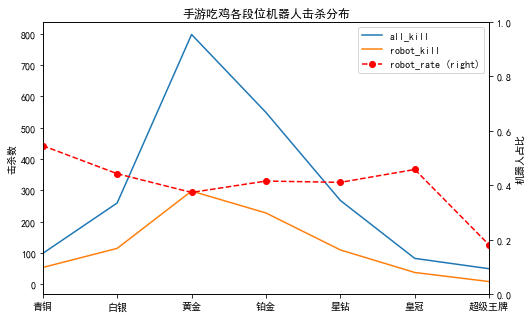

In [120]:
ax = plot_df_1.plot(y =['all_kill', 'robot_kill'], figsize = (8,5))
ax1 = plot_df_1.robot_rate.plot(secondary_y = True, legend = True, style='ro--')
ax.set_ylabel('击杀数')
ax1.set_ylabel('机器人占比')
ax1.set_ylim(0,1)
ax.set_title('手游吃鸡各段位机器人击杀分布')

# 绘制最高击杀 击杀机器人

In [141]:
plot_df_2 = pd.DataFrame()

In [142]:
for data in df['highest_kill_rob_info']:
    if data != []:
        plot_df_2 = plot_df_2.append(data, ignore_index=True)

In [165]:
plot_df_2['rate'] = plot_df_2['kill_rob_num']/plot_df_2['kill_all_num']

In [166]:
plot_df_2.sort_values(by = 'rate',ascending=False, inplace= True)

In [167]:
plot_df_2.reset_index(drop = 'index', inplace = True)

In [168]:
plot_df_2

,kill_all_num,kill_rob_num,rate
0,18,18,1.000000
1,14,14,1.000000
2,12,12,1.000000
3,13,13,1.000000
4,13,13,1.000000
5,18,18,1.000000
6,14,14,1.000000
7,14,14,1.000000
8,13,13,1.000000
9,15,15,1.000000


Text(0.5, 1.0, '朋友圈手游吃鸡最高单场击杀及机器人分布')

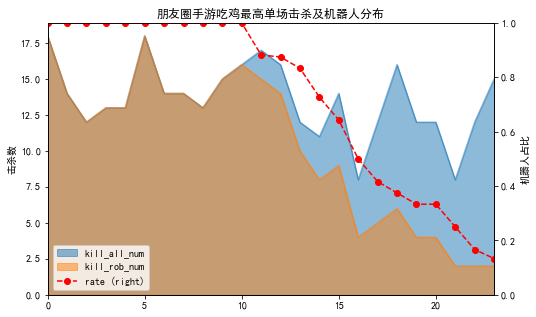

In [176]:
ax = plot_df_2.plot.area(y =['kill_all_num', 'kill_rob_num'], figsize = (8,5), stacked=False)
ax1 = plot_df_2.rate.plot(secondary_y = True, legend = True, style='ro--')
ax.set_ylabel('击杀数')
ax1.set_ylabel('机器人占比')
ax1.set_ylim(0,1)
ax.set_title('朋友圈手游吃鸡最高单场击杀及机器人分布')

In [401]:
import matplotlib.pyplot as plt

In [297]:
tima_rank_df = pd.DataFrame(columns =['rank_desc', 'dt_event_time', 'mode','team_id', 'battle_id'])

In [298]:
for plats in df['recent_list']:
#     print(i[0], i[1])
    for i in range(len(plats)):
        print(len(plats[i]))
        if len(plats[i])!=0: 
            tima_rank_df = tima_rank_df.append(plats[i], ignore_index=True)
#         break

109
0
99
0
0
89
92
20
110
0
0
101
0
110
108
0
102
0
0
26
0
91
0
106
105
4
55
91
13
41
25
80
106
38
93
0
103
74
47
90
0
6
96
0
106
0
104
15
27
23
0
64
0
88


In [299]:
tima_rank_df['rank'] = tima_rank_df['rank_desc'].apply(get_front_rank)

tima_rank_df['time_hour'] = tima_rank_df['dt_event_time'].apply(get_time_hour)

tima_rank_df['time_wday'] = tima_rank_df['dt_event_time'].apply(get_time_wday)

tima_rank_df['mode'] = tima_rank_df['mode'].apply(get_mode)

time_rank_select_df = tima_rank_df[['rank', 'mode', 'time_wday', 'time_hour']]

In [195]:
def get_mode(df):
    mode_type ={101:'单人',102:'双人',103:'四人'}
    return mode_type[df]

In [95]:
def get_time_hour(df):
    return time.localtime(df).tm_hour

In [296]:
def get_time_wday(df):
#     weekday ={0:'星期天',1:'星期一',2:'星期二',3:'星期三',4:'星期四',5:'星期五',6:'星期六'}
    return time.localtime(df).tm_wday

#  段位 场次分布

In [211]:
plot_df_3 = time_rank_select_df.groupby(['mode','rank']).time_wday.count().reset_index()
plot_df_3.columns = ['mode','rank','count']

In [254]:
rank_mode_df = pd.pivot_table(plot_df_3,index='rank',columns = 'mode',values='count').reset_index()

In [257]:
rank_mode_df

mode,rank,单人,双人,四人
0,无敌战神,26.0,22.0,42.0
1,星钻,NaN,4.0,408.0
2,白银,98.0,146.0,134.0
3,皇冠,NaN,NaN,150.0
4,超级王牌,NaN,NaN,27.0
5,铂金,7.0,88.0,502.0
6,青铜,40.0,80.0,60.0
7,黄金,80.0,324.0,419.0


In [259]:
rank_sorted = ['青铜', '白银', '黄金', '铂金', '星钻', '皇冠', '超级王牌','无敌战神']

In [268]:
rank_mode_df['rank'] = rank_mode_df['rank'].astype('category').cat.reorder_categories(rank_sorted)

In [271]:
rank_mode_df.sort_values('rank', inplace = True)

Text(0.5, 0, '段位')

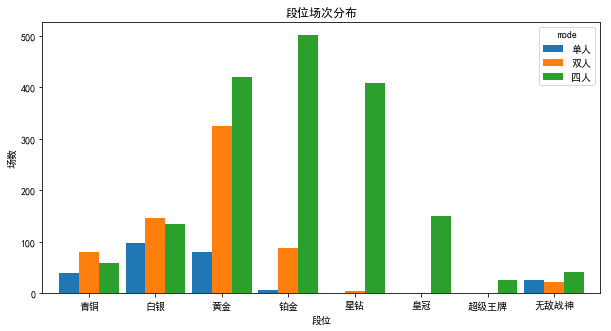

In [278]:
ax =rank_mode_df.plot(kind = 'bar',width =0.9,x = 'rank',figsize = (10,5), title = '段位场次分布', rot = 0)
ax.set_ylabel('场数')
ax.set_xlabel('段位')

# 绘制时间分布图

In [179]:
import collections

In [282]:
hour_hist = collections.Counter(time_rank_select_df['time_hour'].tolist())

In [300]:
wday_hist = collections.Counter(time_rank_select_df['time_wday'].tolist())

In [304]:
weekday ={0:'星期天',1:'星期一',2:'星期二',3:'星期三',4:'星期四',5:'星期五',6:'星期六'}

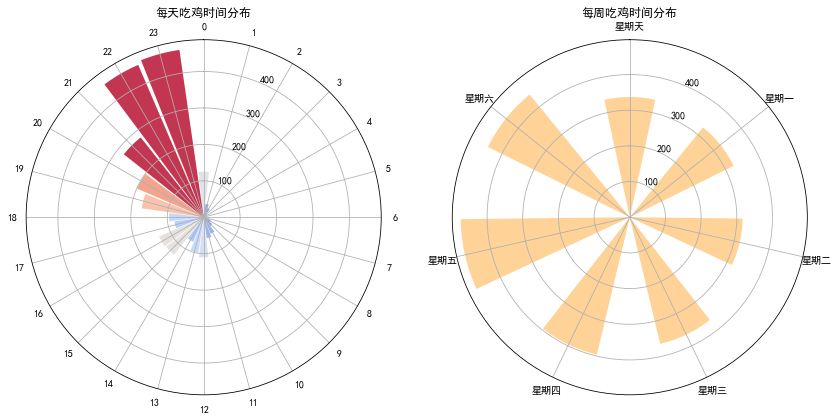

In [309]:
plt.figure(figsize=(14,7))

N1 = 24
# 设置角度轴
theta1 = np.linspace(0.0, 2 * np.pi, N1, endpoint=False)
radii1 = np.array(list(hour_hist.values()))
# 设置圆心角宽度
width1 = np.array([np.pi/12*0.9]*N1)
colors1 = plt.cm.coolwarm(radii1)

ax1 = plt.subplot(121, projection='polar')
ax1.bar(theta1, radii1, width =width1, bottom=0.0, color=colors1, alpha=0.8)
# 设置坐标
ax1.set_thetagrids(np.arange(0.0, 360.0, 360/N1),[str(x) for x in range(N1)])
# 旋角
ax1.set_theta_offset(np.pi/2)
# 顺时针显示
ax1.set_theta_direction(-1)
ax1.set_title('每天吃鸡时间分布')

N2 = 7
# 设置角度轴
theta2 = np.linspace(0.0, 2 * np.pi, N2, endpoint=False)
radii2 = np.array(list(wday_hist.values()))
# 设置圆心角宽度
width2 = np.array([np.pi/N2*0.95]*N2)
colors2 = plt.cm.copper(radii2)

ax2 = plt.subplot(122, projection='polar')
ax2.bar(theta2, radii2, width =width2, bottom=0.0, color=colors2, alpha=0.8)
# 设置坐标
ax2.set_thetagrids(np.arange(0.0, 360.0, 360/N2),[weekday[x] for x in range(N2)])
# 旋角
ax2.set_theta_offset(np.pi/2)
# 顺时针显示
ax2.set_theta_direction(-1)

ax2.set_title('每周吃鸡时间分布')

plt.show()